In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import GRU
from keras import regularizers
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
import itertools  
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import random
from sklearn.utils import resample
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Function to print confusion matrix in a nice format.
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [3]:
##Specifying training data parameters.
years=range(2000,2019)
#years=range(2000,2010)
num_years=5
#Features/columns that will be used for prediction.
#features=["count","neighborCountyAvg", "Gini", "Temp", "Prec", "Hum", "County_type", "Incident_nominal", Resident_population_White_alone_percent", "Median_Household_Income", "Poverty_percent_of_people"]
#features=["count","neighborCountyAvg", "Gini", "Temp", "Prec", "Hum", "County_type","Incident_nominal"]
features=["count","neighborCountyAvg","Incident_nominal"]

In [871]:
#Importing training and testing data
train_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/Temporal_df.csv"
temporal_df=pd.read_csv(train_path)
test_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/Temporal_df_test.csv"
temporal_df_test=pd.read_csv(test_path)

In [872]:
#Importing county names
county_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/County_name.csv"
df_county=pd.read_csv(county_path)

In [873]:
temporal_df.head()

,A,B,C,D,E,F,G,H,I,J,...,6,7,8,9,10,11,12,13,14,15
0,1,0.000000,1,0,0.2,1,0,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0.666667,1,0,1.0,1,0,0.333333,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,1,0,0.0,1,0,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.500000,1,1,0.0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.333333,0,0,0.0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [874]:
#Checking frequency of instances for each class
dict_freq={}
for i in range(1,16):
    dict_freq[i]=len(temporal_df[temporal_df[str(i)]==1])
dict_freq

{1: 35220,
 2: 4654,
 3: 312,
 4: 88,
 5: 39,
 6: 28,
 7: 13,
 8: 8,
 9: 5,
 10: 5,
 11: 5,
 12: 15,
 13: 7,
 14: 3,
 15: 2}

In [875]:
#Using unbalanced data
temporal_df = temporal_df.sample(frac = 1,random_state=5) #Shuffling the data
X_pre = temporal_df.iloc[:, 0:(num_years*len(features))]
Y_pre = temporal_df.iloc[:, (num_years*len(features)):]
X=X_pre.values
Y=Y_pre.values

In [876]:
X_pre

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
2464,0,0.000000,1,0,0.000000,1,0,0.000000,1,1,0.000000,1,0,0.000000,1
10648,0,0.500000,1,0,0.166667,1,0,0.000000,1,0,0.000000,1,0,0.000000,1
19439,0,0.166667,1,0,0.000000,1,0,0.166667,1,0,0.166667,1,0,0.000000,1
24858,0,0.250000,0,0,0.000000,0,0,3.000000,0,0,2.250000,0,0,0.000000,0
21089,0,0.000000,1,0,0.000000,1,0,0.000000,1,0,0.000000,1,1,0.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,2,0.166667,1,0,0.000000,1,3,0.333333,1,1,0.000000,1,0,0.166667,1
35814,1,0.600000,1,0,0.000000,1,2,1.800000,0,0,1.000000,0,0,0.000000,0
20463,0,0.000000,0,0,0.000000,0,0,0.000000,0,0,0.000000,0,0,0.000000,0
18638,0,0.000000,1,0,0.285714,1,0,0.285714,1,0,0.000000,1,0,0.714286,1


In [877]:
#Shows all the class labels are now equally represented
y=np.argmax(Y, axis=1)
np.bincount(y)

array([35220,  4654,   312,    88,    39,    28,    13,     8,     5,
           5,     5,    15,     7,     3,     2])

In [878]:
# # Calculating classs weights based on their frequencies
# y=np.argmax(temporal_df.iloc[:,-15:].values, axis=1)
# class_weights=compute_class_weight("balanced", [i for i in range(15)], y)

## LSTM Implementation for classification

In [879]:
def create_network():
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(4, activation="tanh"))
    network.add(LSTM(15, dropout = 0.2, recurrent_dropout = 0.2, activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return network

In [880]:
#Cross-validation setup
acc_train=[]
acc_val=[]
kf = KFold(n_splits=2, shuffle=True)
for train_index, val_index in kf.split(X):   
    X_pre_train = temporal_df.iloc[train_index, 0:(num_years*len(features))]
    Y_pre_train = temporal_df.iloc[train_index, (num_years*len(features)):]
    X_pre_val = temporal_df.iloc[val_index, 0:(num_years*len(features))]
    Y_pre_val = temporal_df.iloc[val_index, (num_years*len(features)):]
    X_pre_train_combine=pd.concat([X_pre_train, Y_pre_train], axis=1)
    
    #Oversampling the training data to balance the classes
    num_cl=len(X_pre_train_combine[X_pre_train_combine["1"]==1])
    df_balanced=X_pre_train_combine[X_pre_train_combine["1"]==1]
    for i in range(2,16):
        df_temp=X_pre_train_combine[X_pre_train_combine[str(i)]==1]
        if(len(df_temp)>0):
            df_minority_upsampled = resample(df_temp, replace=True, n_samples=num_cl, random_state=4)
            df_balanced=pd.concat([df_balanced, df_minority_upsampled])
    df_balanced_train = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
    X_pre_train = df_balanced_train.iloc[:, 0:(num_years*len(features))]
    Y_pre_train = df_balanced_train.iloc[:, (num_years*len(features)):]
    
    
    X_train=X_pre_train.values
    Y_train=Y_pre_train.values
    X_val=X_pre_val.values
    Y_val=Y_pre_val.values
    
    #Transforming input variables into LSTM input format
    X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
    X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
    Y_train=Y_train
    Y_val=Y_val
    
    #Creating model
    model=create_network()
    Hist=model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
    #Final epoch accuracies for training and validation dataset
    acc_train.append(Hist.history["accuracy"][-1])
    acc_val.append(Hist.history["val_accuracy"][-1])
    
print("Training accuracy:" + str(np.mean(acc_train)))
print("Validation accuracy:" + str(np.mean(acc_val)))
    

Train on 264315 samples, validate on 20202 samples
Epoch 1/1
 - 26s - loss: 1.4763 - accuracy: 0.5086 - val_loss: 1.3765 - val_accuracy: 0.5808
Train on 246386 samples, validate on 20202 samples
Epoch 1/1
 - 25s - loss: 1.3250 - accuracy: 0.5365 - val_loss: 1.2127 - val_accuracy: 0.5490
Training accuracy:0.5225438
Validation accuracy:0.5648698210716248


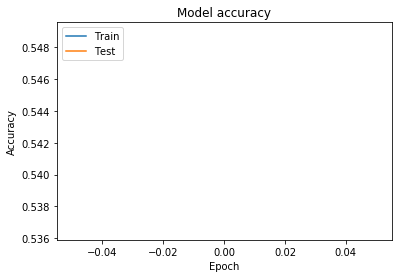

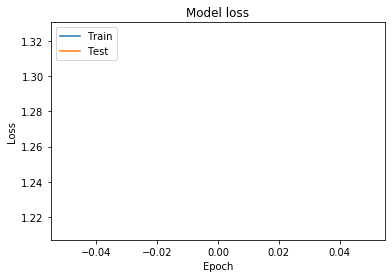

In [881]:
# Plot training & validation accuracy values
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [882]:
X_test=temporal_df_test.values
X_test = X_test.reshape(X_test.shape[0], num_years, len(features))

In [883]:
#Predicting value for train, val, and test datasets
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)
pred_test=model.predict(X_test)

In [829]:
# #Using stochastic random number generation method for assigning class labels
# pred_train_class=[]
# for i in range(pred_train.shape[0]):
#     t=list(pred_train[i])
#     idx=np.argsort(t)+1
#     t.sort()
#     t=np.cumsum(t)
#     rand_num=random.uniform(0, 1)
#     index=0
#     for j in range(len(t)):
#         if(t[j]>=rand_num):
#             index=j
#             break
#     label=idx[index]
#     pred_train_class.append(label)
    
# pred_val_class=[]
# for i in range(pred_val.shape[0]):
#     t=list(pred_val[i])
#     idx=np.argsort(t)+1
#     t.sort()
#     t=np.cumsum(t)
#     rand_num=random.uniform(0, 1)
#     index=0
#     for j in range(len(t)):
#         if(t[j]>=rand_num):
#             index=j
#             break
#     label=idx[index]
#     pred_val_class.append(label)
# pred_train_class=list(map(lambda x: str(x), pred_train_class))
# pred_val_class=list(map(lambda x: str(x), pred_val_class))

In [884]:
#Converting probabilities to class labels
pred_train_class=np.argmax(pred_train, axis=1)+1
pred_train_class=list(map(lambda x: str(x), pred_train_class))
pred_val_class=np.argmax(pred_val, axis=1)+1
pred_val_class=list(map(lambda x: str(x), pred_val_class))
pred_test_class=np.argmax(pred_test, axis=1)+1

In [885]:
true_train_class=np.argmax(Y_train, axis=1)+1
true_train_class=list(map(lambda x: str(x), true_train_class))
true_val_class=np.argmax(Y_val, axis=1)+1
true_val_class=list(map(lambda x: str(x), true_val_class))

In [886]:
labels = [str(i) for i in range(1,16)]
cm_train = confusion_matrix(true_train_class, pred_train_class , labels)
#cm_train=cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] #For normalizing
cm_val = confusion_matrix(true_val_class, pred_val_class , labels)
#cm_val=cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis] #For normalizing

In [887]:
print_cm(cm_train, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 10259.0 4548.0 267.0  44.0 677.0  44.0  43.0 1708.0   0.0   0.0   4.0   5.0   0.0   0.0   0.0 
        2 3993.0 6798.0 1417.0 304.0 1431.0 388.0 283.0 2889.0   0.0   0.0  45.0  38.0   0.0  13.0   0.0 
        3 935.0 3116.0 3729.0 2032.0 1683.0 1313.0 1387.0 2100.0   0.0   0.0 503.0 582.0   0.0 219.0   0.0 
        4   0.0 4342.0 2409.0 3681.0 1732.0 1342.0 1713.0 1340.0   0.0 338.0   0.0 702.0   0.0   0.0   0.0 
        5   0.0 2012.0 1940.0 936.0 9797.0   0.0 974.0   0.0   0.0 1009.0 931.0   0.0   0.0   0.0   0.0 
        6 2768.0 1329.0 1328.0   0.0   0.0 8142.0   0.0 1353.0   0.0 1350.0   0.0 1329.0   0.0   0.0   0.0 
        7   0.0   0.0   0.0   0.0   0.0   0.0 17599.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        8   0.0   0.0   0.0   0.0   0.0   0.0   0.0 17599.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        9   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

In [888]:
print_cm(cm_val, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 10115.0 4681.0 290.0  43.0 696.0  48.0  39.0 1697.0   0.0   0.0   9.0   2.0   0.0   1.0   0.0 
        2 504.0 938.0 188.0  37.0 162.0  30.0  44.0 388.0   0.0   0.0   8.0   3.0   0.0   7.0   0.0 
        3   9.0  32.0  29.0  14.0  16.0  27.0   8.0  26.0   0.0   1.0   4.0   0.0   0.0   0.0   0.0 
        4   1.0   3.0   4.0   2.0   8.0   5.0   3.0   4.0   0.0   0.0   2.0   2.0   0.0   2.0   0.0 
        5   1.0   2.0   3.0   3.0   1.0   1.0   3.0   4.0   0.0   0.0   2.0   1.0   0.0   0.0   0.0 
        6   2.0   1.0   3.0   0.0   0.0   2.0   1.0   1.0   0.0   0.0   2.0   1.0   0.0   2.0   0.0 
        7   1.0   0.0   1.0   0.0   2.0   1.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0 
        8   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   2.0   1.0   0.0   0.0   0.0 
        9   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   1.0   0.0   0.0   0.0

In [889]:
#Evaluation metrics for valdation dataset
print(metrics.classification_report(true_val_class, pred_val_class))

              precision    recall  f1-score   support

           1       0.95      0.57      0.72     17621
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.09      0.33      0.14         3
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
           2       0.17      0.41      0.24      2309
           3       0.06      0.17      0.08       166
           4       0.02      0.06      0.03        36
           5       0.00      0.05      0.00        21
           6       0.02      0.13      0.03        15
           7       0.01      0.14      0.02         7
           8       0.00      0.17      0.00         6
           9       0.00      0.00      0.00         4

    accuracy                           0.55     20202
   macro avg       0.09      0.14      0.08     20202
weighted avg       0.85   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [836]:
# #If weather data is used i.e. some counties are missing
# df_county
# df_1=pd.DataFrame(pred_test, columns=[i for i in range(1,16)])
# df_county=pd.concat([df_county, df_1], axis=1)
# df_county.to_csv("/Users/sparshagarwal/Desktop/NCSA/Dataframes/df_county_missing.csv", index=False)

In [890]:
# #If weather data is not used i.e. all counties are there
# df_1=pd.DataFrame(pred_test, columns=[i for i in range(1,16)])
# df_county=pd.concat([df_county, df_1], axis=1)
# df_county.to_csv("/Users/sparshagarwal/Desktop/NCSA/Dataframes/df_county_complete.csv", index=False)

In [4]:
#Importing missing and complete dataframes
df_missing=pd.read_csv("/Users/sparshagarwal/Desktop/NCSA/Dataframes/df_county_missing.csv")
df_complete=pd.read_csv("/Users/sparshagarwal/Desktop/NCSA/Dataframes/df_county_complete.csv")

In [5]:
#Generating final complete dataframe
list_1=set(df_missing["name"])
list_2=set(df_complete["name"])
diff=list(list_2-list_1)
for county in diff:
    row_add=df_complete[df_complete["name"]==county]
    df_missing=pd.concat([df_missing, row_add])
df_final=df_missing.sort_values(by=["name"])

In [6]:
diff

['Massachusetts-Nantucket',
 'Virginia-Lancaster',
 'Maryland-Calvert',
 'Washington-San Juan',
 'Virginia-Northumberland',
 'South Dakota-Oglala Lakota',
 'Wisconsin-Ozaukee']

Generating test data frame results

In [904]:
result_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/WNV_forecasting_template (4-20-2020).csv"
df_result=pd.read_csv(result_path)

In [906]:
values=[]
for i in range(len(df_final)):
    values.append(1)
    for j in range(1,16):
        values.append(df_final.iloc[i][str(j)])

In [907]:
df_result["value"]=values

In [910]:
df_result.to_csv("/Users/sparshagarwal/Desktop/NCSA/Dataframes/WNV_forecasting_results.csv", index=False)